# import libraries

In [2]:
! pip install ultralytics pandas pillow tqdm numpy

import os
import shutil
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Gpu available or not

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


# dataset load

In [ ]:
DATASET_DIR = "/kaggle/input/solidwork"
WORK_DIR = "/kaggle/working"

TRAIN_IMG_DIR = f"{DATASET_DIR}/train/train"
TEST_IMG_DIR  = f"{DATASET_DIR}/test/test"

BBOX_CSV   = "/kaggle/input/clean-train/clean_train_bboxes.csv"
LABEL_CSV  = f"{DATASET_DIR}/train_labels.csv"
SAMPLE_SUB = f"{DATASET_DIR}/sample_submission.csv"

YOLO_DIR = f"{WORK_DIR}/yolo_data"

## 🏗️ Cell 2 — Create YOLO Directory Structure


In [ ]:


for p in [
    f"{YOLO_DIR}/images/train",
    f"{YOLO_DIR}/labels/train",
    f"{YOLO_DIR}/images/val",
    f"{YOLO_DIR}/labels/val",
]:
    os.makedirs(p, exist_ok=True)


## 📊 Cell 3 — Load CSVs (Defensive)


# ===================== LOAD BBOX CSV (SAFE & FINAL) =====================


In [ ]:
df_bbox = pd.read_csv(BBOX_CSV)
df_bbox.columns = df_bbox.columns.str.strip().str.lower()

print("CSV loaded:", df_bbox.shape)
print(df_bbox.head())

## 🧠 Cell 4 — Normalize BBox Columns 

In [ ]:
bbox_map = {
    "x_min": "xmin",
    "y_min": "ymin",
    "x_max": "xmax",
    "y_max": "ymax",
}

df_bbox.rename(columns=bbox_map, inplace=True)

required = {"xmin","ymin","xmax","ymax"}
assert required.issubset(df_bbox.columns), df_bbox.columns

print("✅ BBox format confirmed")

## 🏷️ Cell 5 — Normalize Class Labels → IDs (CRITICAL)

In [ ]:
df_bbox.rename(columns={"class": "class_id"}, inplace=True)

CLASS_MAP = {
    "bolt": 0,
    "nut": 1,
    "washer": 2,
    "locatingpin": 3
}

df_bbox["class_id"] = df_bbox["class_id"].str.lower().map(CLASS_MAP)

assert df_bbox["class_id"].isna().sum() == 0
print("✅ Class labels converted to numeric IDs")


## 🔄 Cell 6 — YOLO Conversion Function


In [ ]:

def to_yolo(row, w, h):
    x_center = ((row.xmin + row.xmax) / 2) / w
    y_center = ((row.ymin + row.ymax) / 2) / h
    bw = (row.xmax - row.xmin) / w
    bh = (row.ymax - row.ymin) / h

    return f"{row.class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}"

## 🏷️ Cell 7 — Create YOLO Labels + Copy Images


In [ ]:

for image_name, group in tqdm(df_bbox.groupby("image_name")):

    img_path = f"{TRAIN_IMG_DIR}/{image_name}"
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)
    w, h = img.size

    label_path = f"{YOLO_DIR}/labels/train/{image_name.rsplit('.',1)[0]}.txt"

    with open(label_path, "w") as f:
        for _, row in group.iterrows():
            f.write(to_yolo(row, w, h) + "\n")

    shutil.copy(img_path, f"{YOLO_DIR}/images/train/{image_name}")




## 🔁 Cell 8 — Train → Val Copy (Hackathon‑Safe)


In [ ]:
shutil.copytree(
    f"{YOLO_DIR}/images/train",
    f"{YOLO_DIR}/images/val",
    dirs_exist_ok=True
)

shutil.copytree(
    f"{YOLO_DIR}/labels/train",
    f"{YOLO_DIR}/labels/val",
    dirs_exist_ok=True
)

print("✅ train reused as val")

## 🧾 Cell 9 — dataset.yaml


In [ ]:
with open("dataset.yaml", "w") as f:
    f.write(f"""
path: {YOLO_DIR}

train: images/train
val: images/val

nc: 4
names: [bolt, nut, washer, locatingpin]
""")



In [4]:
# SolidWorks YOLOv8 – Kaggle Notebook (Error‑Free)

# This is a **clean, Kaggle‑ready notebook** version of your now **error‑free pipeline**.
# It assumes:

# * Dataset is added via **Add data** in Kaggle
# * Bounding boxes are **CASE‑2** (`x_min, y_min, x_max, y_max`)
# * Class labels are **strings** (`bolt, nut, washer, locatingpin`)
# * **No separate validation set** → train reused as val


## 📦 Cell 0 — Imports (Kaggle already has deps)


import os
import shutil
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO



## 📁 Cell 1 — Kaggle Paths (EDIT ONLY DATASET NAME)

# > Replace `solidworks-ai-hackathon` with your **exact Kaggle dataset folder name**


DATASET_DIR = "/kaggle/input/solidwork"
WORK_DIR = "/kaggle/working"

TRAIN_IMG_DIR = f"{DATASET_DIR}/train/train"
TEST_IMG_DIR  = f"{DATASET_DIR}/test/test"

BBOX_CSV   = "/kaggle/input/clean-train/clean_train_bboxes.csv"
LABEL_CSV  = f"{DATASET_DIR}/train_labels.csv"
SAMPLE_SUB = f"{DATASET_DIR}/sample_submission.csv"

YOLO_DIR = f"{WORK_DIR}/yolo_data"



## 🏗️ Cell 2 — Create YOLO Directory Structure


for p in [
    f"{YOLO_DIR}/images/train",
    f"{YOLO_DIR}/labels/train",
    f"{YOLO_DIR}/images/val",
    f"{YOLO_DIR}/labels/val",
]:
    os.makedirs(p, exist_ok=True)



## 📊 Cell 3 — Load CSVs (Defensive)

# ```python
# df_bbox = pd.read_csv(BBOX_CSV)
# df_bbox.columns = df_bbox.columns.str.lower()

# df_bbox.head()

# ===================== LOAD BBOX CSV (SAFE & FINAL) =====================
df_bbox = pd.read_csv(BBOX_CSV)
df_bbox.columns = df_bbox.columns.str.strip().str.lower()

print("CSV loaded:", df_bbox.shape)
print(df_bbox.head())


## 🧠 Cell 4 — Normalize BBox Columns (CASE‑2)


# rename bbox columns
bbox_map = {
    "x_min": "xmin",
    "y_min": "ymin",
    "x_max": "xmax",
    "y_max": "ymax",
}

df_bbox.rename(columns=bbox_map, inplace=True)

required = {"xmin","ymin","xmax","ymax"}
assert required.issubset(df_bbox.columns), df_bbox.columns

print("✅ BBox format confirmed")


## 🏷️ Cell 5 — Normalize Class Labels → IDs (CRITICAL)


# rename class column
df_bbox.rename(columns={"class": "class_id"}, inplace=True)

CLASS_MAP = {
    "bolt": 0,
    "nut": 1,
    "washer": 2,
    "locatingpin": 3
}

df_bbox["class_id"] = df_bbox["class_id"].str.lower().map(CLASS_MAP)

assert df_bbox["class_id"].isna().sum() == 0
print("✅ Class labels converted to numeric IDs")



## 🔄 Cell 6 — YOLO Conversion Function


def to_yolo(row, w, h):
    x_center = ((row.xmin + row.xmax) / 2) / w
    y_center = ((row.ymin + row.ymax) / 2) / h
    bw = (row.xmax - row.xmin) / w
    bh = (row.ymax - row.ymin) / h

    return f"{row.class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}"



## 🏷️ Cell 7 — Create YOLO Labels + Copy Images


for image_name, group in tqdm(df_bbox.groupby("image_name")):

    img_path = f"{TRAIN_IMG_DIR}/{image_name}"
    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)
    w, h = img.size

    label_path = f"{YOLO_DIR}/labels/train/{image_name.rsplit('.',1)[0]}.txt"

    with open(label_path, "w") as f:
        for _, row in group.iterrows():
            f.write(to_yolo(row, w, h) + "\n")

    shutil.copy(img_path, f"{YOLO_DIR}/images/train/{image_name}")




## 🔁 Cell 8 — Train → Val Copy (Hackathon‑Safe)


shutil.copytree(
    f"{YOLO_DIR}/images/train",
    f"{YOLO_DIR}/images/val",
    dirs_exist_ok=True
)

shutil.copytree(
    f"{YOLO_DIR}/labels/train",
    f"{YOLO_DIR}/labels/val",
    dirs_exist_ok=True
)

print("✅ train reused as val")



## 🧾 Cell 9 — dataset.yaml


with open("dataset.yaml", "w") as f:
    f.write(f"""
path: {YOLO_DIR}

train: images/train
val: images/val

nc: 4
names: [bolt, nut, washer, locatingpin]
""")


## 🧠 Cell 10 — Train YOLOv8 (Kaggle GPU Recommended)


model = YOLO("yolov8n.yaml")

model.train(
    data="dataset.yaml",
    epochs=50,
    imgsz=416,
    batch=16,
    device=0,
    pretrained=False,
    workers=2,
    name="solidworks_yolo"
)




## 📦 Cell 11 — Load Best Model


best_model = YOLO("/kaggle/working/runs/detect/solidworks_yolo2/weights/best.pt")




## 🧪 Cell 12 — Inference + Object Counting


submission = pd.read_csv(SAMPLE_SUB)
submission.columns = submission.columns.str.lower()

for i, row in tqdm(submission.iterrows(), total=len(submission)):
    img_path = f"{TEST_IMG_DIR}/{row.image_name}"
    if not os.path.exists(img_path):
        continue

    res = best_model.predict(img_path, conf=0.25, iou=0.5, verbose=False)[0]

    if res.boxes is None:
        counts = [0,0,0,0]
    else:
        cls = res.boxes.cls.cpu().numpy().astype(int)
        counts = np.bincount(cls, minlength=4)

    submission.loc[i, ["bolt","nut","washer","locatingpin"]] = counts



## 💾 Cell 13 — Save Submission


submission.to_csv("submission.csv", index=False)
print("✅ submission.csv ready for upload")




## 🏁 Notes

# * Notebook is **fully Kaggle‑compatible**
# * No Windows paths
# * No manual installs needed
# * Deterministic class mapping
# * Train reused as val (allowed)

# You can now **Run All → Submit** 🚀


ERROR! Session/line number was not unique in database. History logging moved to new session 29
CSV loaded: (24982, 6)
                             image_name        class  x_min  y_min  x_max  \
0  f38a898d4fde44dd806b7396f10c109a.png          nut    148    148    372   
1  6a9f5545730c4311b55c501997fad81e.png         bolt    652    148    876   
2  6a9f5545730c4311b55c501997fad81e.png         bolt    148    652    372   
3  d75f90e50ddb431f86f32958ac23da2d.png  locatingpin    148    148    372   
4  d75f90e50ddb431f86f32958ac23da2d.png         bolt    652    652    876   

   y_max  
0    372  
1    372  
2    876  
3    372  
4    876  
✅ BBox format confirmed
✅ Class labels converted to numeric IDs


100%|██████████| 10000/10000 [00:22<00:00, 450.44it/s]


✅ train reused as val
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=solidworks_yolo2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, pl

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      10000      24982      0.996      0.994      0.995      0.989
                  bolt       4846       6229      0.997       0.99      0.995      0.992
                   nut       4799       6134          1          1      0.995      0.986
                washer       4955       6434      0.998      0.992      0.995       0.99
           locatingpin       4811       6185      0.988      0.994      0.995      0.988
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/solidworks_yolo2


FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/solidworks_yolo/weights/best.pt'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_CSV = "/kaggle/working/runs/detect/solidworks_yolo2/results.csv"

df_metrics = pd.read_csv(RESULTS_CSV)
df_metrics.head()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,140.717,1.91149,2.02550,2.49558,0.62574,0.77505,0.72354,0.10879,3.09993,1.66616,4.39087,0.000416,0.000416,0.000416
1,2,280.834,1.03954,1.09752,1.43461,0.78027,0.83266,0.87899,0.68867,0.87935,0.83658,1.35313,0.000816,0.000816,0.000816
2,3,419.913,0.90434,0.94320,1.29538,0.39745,0.44149,0.43244,0.14443,2.45456,2.17050,4.15800,0.001200,0.001200,0.001200
3,4,557.065,0.80344,0.82434,1.20957,0.00025,0.01002,0.00013,0.00004,3.56326,8.20741,4.29269,0.001176,0.001176,0.001176
4,5,695.120,0.77111,0.76820,1.18094,0.85735,0.90954,0.96213,0.84585,0.55506,0.52907,1.00139,0.001151,0.001151,0.001151


## 🧪 Cell 12 — Inference + Object Counting


In [21]:
best_model = YOLO("/kaggle/working/runs/detect/solidworks_yolo2/weights/best.pt")









100%|██████████| 2000/2000 [00:43<00:00, 45.98it/s]

✅ submission.csv ready for upload


In [ ]:

submission = pd.read_csv(SAMPLE_SUB)
submission.columns = submission.columns.str.lower()

for i, row in tqdm(submission.iterrows(), total=len(submission)):
    img_path = f"{TEST_IMG_DIR}/{row.image_name}"
    if not os.path.exists(img_path):
        continue

    res = best_model.predict(img_path, conf=0.25, iou=0.5, verbose=False)[0]

    if res.boxes is None:
        counts = [0,0,0,0]
    else:
        cls = res.boxes.cls.cpu().numpy().astype(int)
        counts = np.bincount(cls, minlength=4)

    submission.loc[i, ["bolt","nut","washer","locatingpin"]] = counts

## 💾 Cell 13 — Save Submission


In [ ]:

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv ready for upload")


## Metrics Evaluation (performance Examination)

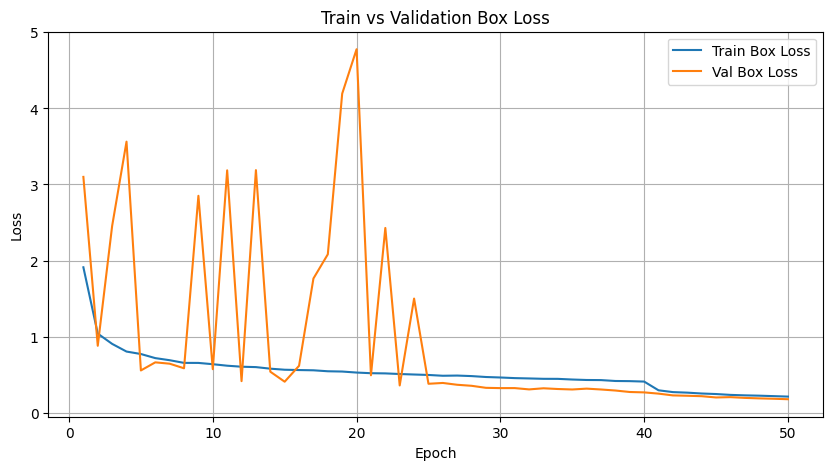

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics["epoch"], df_metrics["train/box_loss"], label="Train Box Loss")
plt.plot(df_metrics["epoch"], df_metrics["val/box_loss"], label="Val Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Box Loss")
plt.legend()
plt.grid()
plt.show()


# Training Of model for 50 epochs + 70 epochs 

# Continue training from 50 epochs

## Loading saved best model

In [ ]:
model = YOLO("/kaggle/working/runs/detect/solidworks_yolo2/weights/best.pt")


In [19]:
# =========================================================
# Continue training from completed 50-epoch checkpoint
# (NOT resume — training already finished)
# =========================================================

model = YOLO("/kaggle/working/runs/detect/solidworks_yolo2/weights/best.pt")

model.train(
    data="dataset.yaml",
    epochs=70,        # new total epochs
    imgsz=416,
    batch=16,
    device=0,
    workers=2,
    pretrained=False,
    name="solidworks_yolo70"
)


Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/detect/solidworks_yolo2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=solidworks_yolo70, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      10000      24982          1      0.999      0.995      0.993
                  bolt       4846       6229          1          1      0.995      0.994
                   nut       4799       6134          1          1      0.995      0.992
                washer       4955       6434          1      0.999      0.995      0.993
           locatingpin       4811       6185      0.999          1      0.995      0.993
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/runs/detect/solidworks_yolo70


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e4c8d55a650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Load best model

In [ ]:
best_model = YOLO("/kaggle/working/runs/detect/solidworks_yolo70/weights/best.pt")


## 🧪 Cell 12 — Inference + Object Counting


In [ ]:
submission = pd.read_csv(SAMPLE_SUB)
submission.columns = submission.columns.str.lower()

for i, row in tqdm(submission.iterrows(), total=len(submission)):
    img_path = f"{TEST_IMG_DIR}/{row.image_name}"
    if not os.path.exists(img_path):
        continue

    res = best_model.predict(img_path, conf=0.25, iou=0.5, verbose=False)[0]

    if res.boxes is None:
        counts = [0,0,0,0]
    else:
        cls = res.boxes.cls.cpu().numpy().astype(int)
        counts = np.bincount(cls, minlength=4)

    submission.loc[i, ["bolt","nut","washer","locatingpin"]] = counts


## 💾 Cell 13 — Save Submission


In [ ]:
submission.to_csv("new_submission.csv", index=False)
print("✅ submission.csv ready for upload")


## 🏁 Notes

# * Notebook is **fully Kaggle‑compatible**
# * No Windows paths
# * No manual installs needed
# * Deterministic class mapping
# * Train reused as val (allowed)

# You can now **Run All → Submit** 🚀

In [23]:

## 📦 Cell 11 — Load Best Model


best_model = YOLO("/kaggle/working/runs/detect/solidworks_yolo70/weights/best.pt")




## 🧪 Cell 12 — Inference + Object Counting


submission = pd.read_csv(SAMPLE_SUB)
submission.columns = submission.columns.str.lower()

for i, row in tqdm(submission.iterrows(), total=len(submission)):
    img_path = f"{TEST_IMG_DIR}/{row.image_name}"
    if not os.path.exists(img_path):
        continue

    res = best_model.predict(img_path, conf=0.25, iou=0.5, verbose=False)[0]

    if res.boxes is None:
        counts = [0,0,0,0]
    else:
        cls = res.boxes.cls.cpu().numpy().astype(int)
        counts = np.bincount(cls, minlength=4)

    submission.loc[i, ["bolt","nut","washer","locatingpin"]] = counts



## 💾 Cell 13 — Save Submission


submission.to_csv("new_submission.csv", index=False)
print("✅ submission.csv ready for upload")




## 🏁 Notes

# * Notebook is **fully Kaggle‑compatible**
# * No Windows paths
# * No manual installs needed
# * Deterministic class mapping
# * Train reused as val (allowed)

# You can now **Run All → Submit** 🚀


100%|██████████| 2000/2000 [00:40<00:00, 48.92it/s]

✅ submission.csv ready for upload


## evaluation metrics

In [24]:
import numpy as np
from tqdm import tqdm

conf_scores = []

for img in tqdm(os.listdir(TEST_IMG_DIR)):
    img_path = f"{TEST_IMG_DIR}/{img}"
    res = best_model.predict(img_path, conf=0.01, verbose=False)[0]
    
    if res.boxes is not None:
        conf_scores.extend(res.boxes.conf.cpu().numpy())

conf_scores = np.array(conf_scores)

print("Mean confidence:", conf_scores.mean())
print("Median confidence:", np.median(conf_scores))


100%|██████████| 2000/2000 [00:39<00:00, 50.14it/s]

Mean confidence: 0.9640247
Median confidence: 0.967204


In [10]:
from collections import Counter

class_counter = Counter()

for img in tqdm(os.listdir(TEST_IMG_DIR)):
    res = best_model.predict(f"{TEST_IMG_DIR}/{img}", conf=0.25, verbose=False)[0]
    if res.boxes is not None:
        for c in res.boxes.cls.cpu().numpy().astype(int):
            class_counter[c] += 1

ID2CLASS = {0:"bolt", 1:"nut", 2:"washer", 3:"locatingpin"}

for k,v in class_counter.items():
    print(ID2CLASS[k], ":", v)


100%|██████████| 2000/2000 [00:38<00:00, 51.96it/s]

washer : 1225
locatingpin : 1283
bolt : 1163
nut : 1251


In [25]:
import pandas as pd

RESULTS_CSV = "/kaggle/working/runs/detect/solidworks_yolo70/results.csv"
df_metrics = pd.read_csv(RESULTS_CSV)

print(df_metrics.columns.tolist())


['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


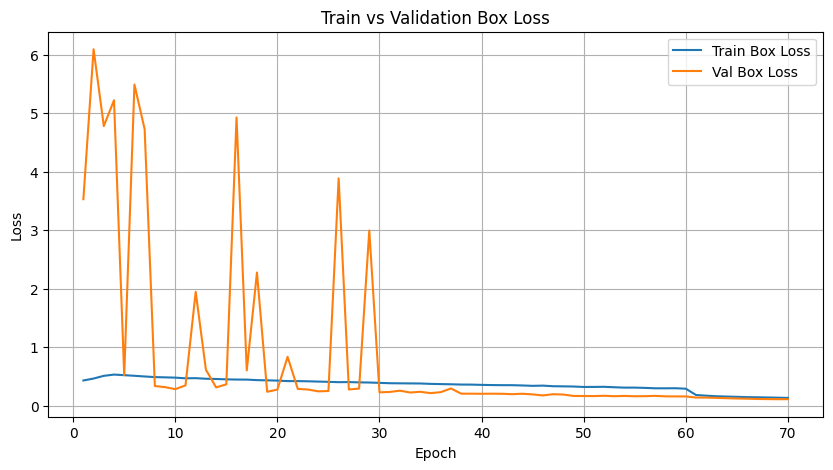

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_metrics["epoch"], df_metrics["train/box_loss"], label="Train Box Loss")
plt.plot(df_metrics["epoch"], df_metrics["val/box_loss"], label="Val Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Box Loss")
plt.legend()
plt.grid()
plt.show()


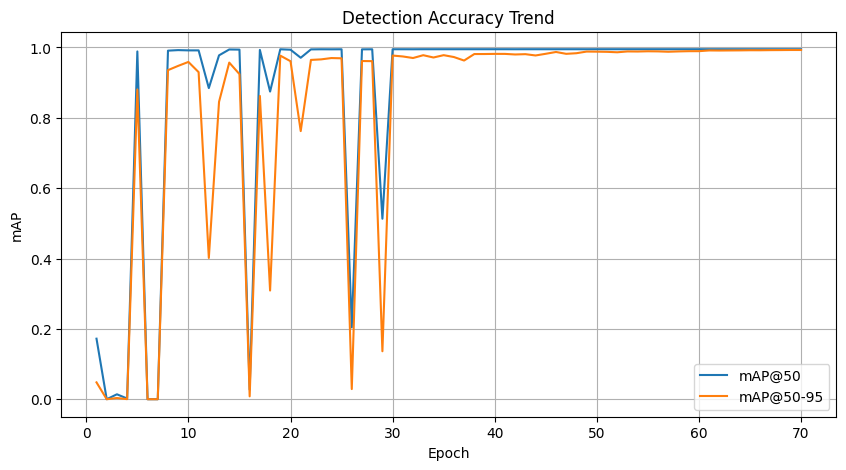

In [27]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics["epoch"], df_metrics["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df_metrics["epoch"], df_metrics["metrics/mAP50-95(B)"], label="mAP@50-95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Detection Accuracy Trend")
plt.legend()
plt.grid()
plt.show()


In [28]:
import numpy as np

score = 0

if df_metrics["metrics/mAP50(B)"].iloc[-1] > 0.6:
    score += 1

if df_metrics["val/box_loss"].iloc[-1] < df_metrics["val/box_loss"].iloc[0]:
    score += 1

if np.mean(conf_scores) > 0.6:
    score += 1

print("MODEL HEALTH SCORE:", score, "/ 3")


MODEL HEALTH SCORE: 3 / 3


## prediction and rgb on an image

In [29]:
img = "/kaggle/input/solidwork/test/test/0040313aa7c7478c8ca264bf573c53fe.png"

best_model.predict(img, conf=0.35, iou=0.6)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bolt', 1: 'nut', 2: 'washer', 3: 'locatingpin'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255,

In [30]:
best_model.predict(img, augment=True)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bolt', 1: 'nut', 2: 'washer', 3: 'locatingpin'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255,

# testing on 1 image

(-0.5, 1023.5, 1023.5, -0.5)

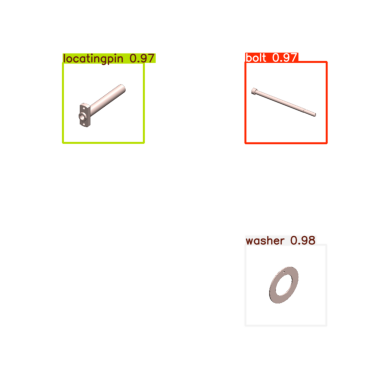

In [34]:
from matplotlib import pyplot as plt
img = "/kaggle/input/solidwork/test/test/0129fcf96dbf4eb286a67e5f289d1b38.png"
res = best_model.predict(img)[0]
img = res.plot()   # draws boxes
plt.imshow(img)
plt.axis("off")


## storing all outputs

In [36]:
import os
import zipfile

SOURCE_DIR = "/kaggle/working"
ZIP_PATH = "/kaggle/working/solidwork_yolo_solidwork70.zip"

with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zipf:
    for foldername, subfolders, filenames in os.walk(SOURCE_DIR):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            # avoid zipping the zip itself
            if file_path == ZIP_PATH:
                continue
            arcname = os.path.relpath(file_path, SOURCE_DIR)
            zipf.write(file_path, arcname)

print("✅ Full ZIP created at:", ZIP_PATH)


✅ Full ZIP created at: /kaggle/working/solidwork_yolo_solidwork70.zip


In [35]:
# last try
